In [1]:
import numpy as np
import matplotlib.pyplot as plt
import multiprocess as mp
import glob
import time
from tqdm import tqdm
import os
import sys
import pandas as pd
from eumap.misc import find_files, nan_percentile, GoogleSheet, ttprint
from eumap.raster import read_rasters, save_rasters
import geopandas as gpd
from pathlib import Path
import warnings
import matplotlib
import matplotlib.pyplot as plt
import joblib
import pickle

df = pd.read_csv('/mnt/inca/soc_eu_model/data/002.1_covar_overlayed.tiled.csv',low_memory=False)
df = df.dropna(subset=['oc'])
df = df.loc[df['oc_qa']>=5]
df['log1p_oc'] = np.log1p(df['oc'])
tgt = 'log1p_oc'
df = df.loc[df['ref']!='nl.bis']

/home/opengeohub/.local/lib/python3.8/site-packages/geopandas/_compat.py:124: UserWarning: The Shapely GEOS version (3.11.3-CAPI-1.17.3) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


In [2]:
# get the grouped covariate list by types
key_file = '/mnt/inca/soc_eu_model/data/gaia-319808-913d36b5fca4.json'
url = 'https://docs.google.com/spreadsheets/d/1eIoPAvWM5jrhLrr25jwguAIR0YxOh3f5-CdXwpcOIz8/edit#gid=0'

gsheet = GoogleSheet(key_file, url)
covar = gsheet.Sheet1

# function to generate file paths by year, and check if the urls are valid
def generate_overlay_path(row, year):
    # Determine if static variable
    if row['temporal resolution'] == 'static':
        return [row['path']], [row['path']], [row['type']]
    
    # Determine if the year is ahead of the availability of the variable
    if year > int(row['end year']):
        year = int(row['end year'])
    
    # Determine if it's an annual variable or (bi)monthly variable
    if '{start_m}' not in row['path']:
        output_paths = [row['path'].replace('{year}', f'{int(year)}')]
    else:
        output_paths = []
        start_list = row['start_m'].split(', ')
        end_list = row['end_m'].split(', ')
        output_paths = [row['path'].replace('{year}', f'{int(year)}').replace('{start_m}', start_list[i]).replace('{end_m}', end_list[i]) for i in range(len(end_list))]
    
    if '{perc}' in row['path']:
        perc_list = row['perc'].split(',')
        output_paths = [p.replace('{perc}', perc) for p in output_paths for perc in perc_list]
        
    if (row['leap year'] == '1') & (year % 4 == 0):
        output_paths = [p.replace('0228', '0229') if '0228' in p else p for p in output_paths]
    
    return output_paths, [i.replace(str(int(year)), '{year}') for i in output_paths], [row['type'] for _ in range(len(output_paths))]
    
pathl = []
namel = []
typel = []
year = 2022
for index,row in covar.iterrows():
    paths, names, types = generate_overlay_path(row, year)
    pathl.extend(paths)
    namel.extend(names)
    typel.extend(types)
    
namel = [i.split('/')[-1][0:-4] for i in namel]

lard2 = [namel[ii] for ii in range(len(typel)) if typel[ii]=='Lard2']
dynamic = [namel[ii] for ii in range(len(typel)) if typel[ii]=='Dynamic']
hybrid = [namel[ii] for ii in range(len(typel)) if typel[ii]=='Hybrid' and namel[ii] in df.columns]
lannual = [namel[ii] for ii in range(len(typel)) if typel[ii]=='Lannual']
static = [namel[ii] for ii in range(len(typel)) if typel[ii]=='Static' and namel[ii] in df.columns]
laccum = [namel[ii] for ii in range(len(typel)) if typel[ii]=='Laccum']
namel = [i for i in namel if i in df.columns]
meta = ['hzn_btm','hzn_top']

df = df.dropna(subset=namel,how='any')

In [3]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GroupKFold
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

featl = [lard2+dynamic+hybrid+lannual+static+laccum+meta, # all
         lard2+dynamic+static+meta, # monthly, bimonthly, static
         hybrid+laccum+lannual+static+meta, # annual + static
         lard2+lannual+laccum+meta, # annual without static
         lard2+dynamic+hybrid+lannual+laccum+meta # all without static
        ]

featn = [
    'all',
    '(bi)monthly+static',
    'annual (hybrid,laccum,lannual) + static',
    'only landsat (lard2,lannual,laccum)',
    'all without static'
]

def calc_ccc(y_true, y_pred):
    mean_true = np.mean(y_true)
    mean_pred = np.mean(y_pred)
    cov_matrix = np.cov(y_true, y_pred)
    covariance = cov_matrix[0, 1]
    var_true = cov_matrix[0, 0]
    var_pred = cov_matrix[1, 1]
    ccc = (2 * covariance) / (var_true + var_pred + (mean_true - mean_pred) ** 2)
    return ccc

def accuracy_plot(y_test, y_pred, title_text):
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    ccc = calc_ccc(y_test, y_pred)
    
    plt.rcParams.update({'font.size': 16})
    fig = plt.figure(figsize=(8, 8))
    fig.suptitle(title_text, fontsize=20, fontweight='bold')
    plt.title(f'R2={r2:.2f}, RMSE={rmse:.4f}, CCC={ccc:.2f}')
    plt.hexbin(y_test, y_pred, gridsize=(300, 300), cmap='plasma_r', mincnt=1, vmax=30)
    
    plt.xlabel('SOC - test')
    plt.ylabel('SOC - pred')
    
    ax = plt.gca()
    ax.set_aspect('auto', adjustable='box')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    ax.plot([0, 6.2], [0, 6.2], "-k", alpha=.5)
    
    cax = fig.add_axes([ax.get_position().x1 + 0.05, ax.get_position().y0, 0.02, ax.get_position().height])
    cb = plt.colorbar(cax=cax)
    
    plt.show()



# spatial cross validation
group_kfold = GroupKFold(n_splits=5)
groups = df['tile_id'] 


[22:00:17] start training on all


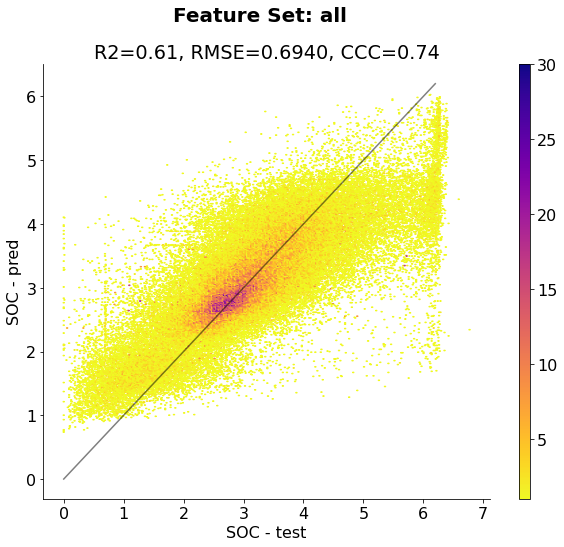

[22:01:29] start training on (bi)monthly+static


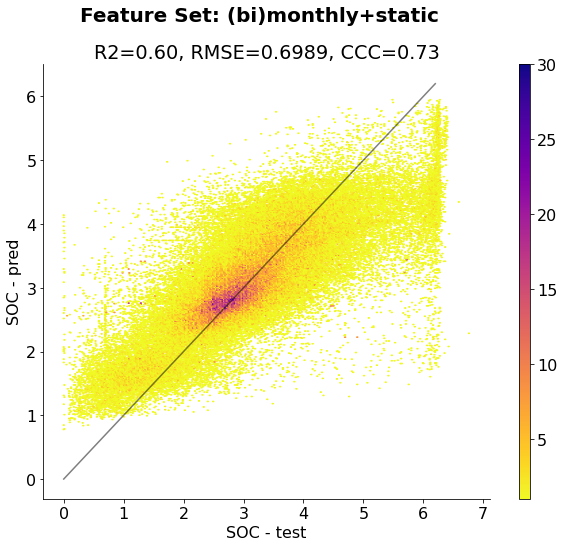

[22:02:33] start training on annual (hybrid,laccum,lannual) + static


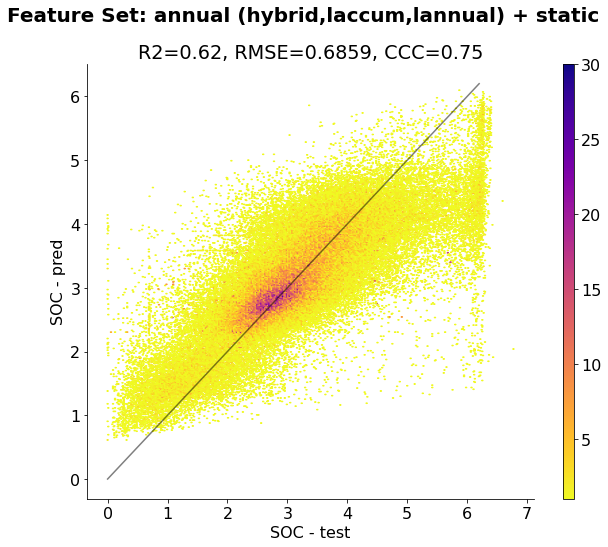

[22:03:14] start training on only landsat (lard2,lannual,laccum)


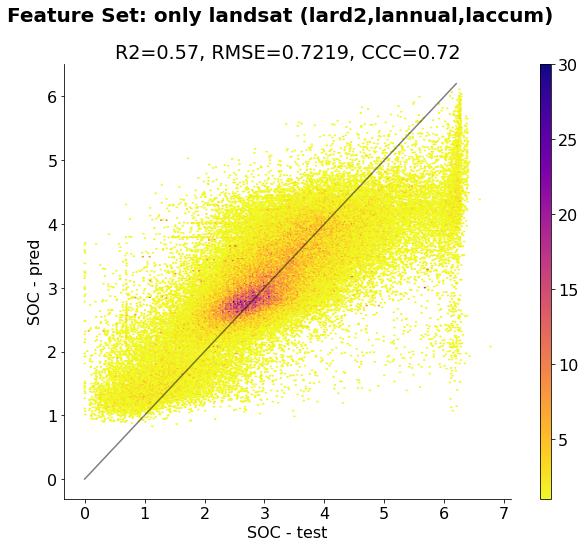

[22:03:52] start training on all without static


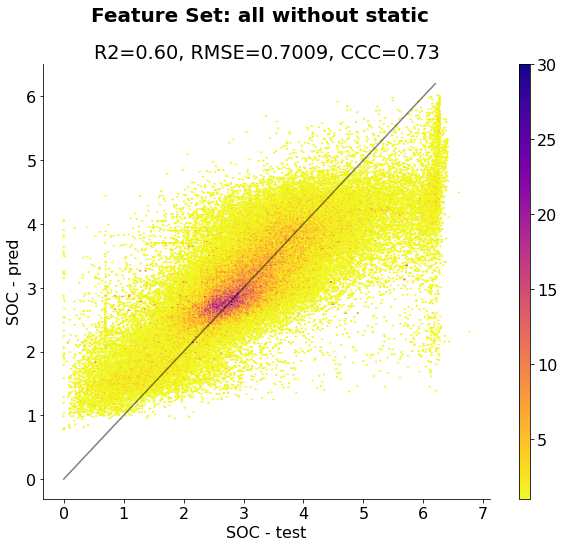

,Feature Set,R2,RMSE,CCC
0,all,0.567573,0.708036,0.708379
1,(bi)monthly+static,0.560207,0.714041,0.702709
2,"annual (hybrid,laccum,lannual) + static",0.576675,0.700544,0.722029
3,"only landsat (lard2,lannual,laccum)",0.529215,0.738772,0.683251
4,all without static,0.558691,0.715270,0.700792


In [7]:
results = []
for features, feature_name in zip(featl, featn):
    X = df[features]
    y = df[tgt]  
    
    y_actual_all = np.array([])
    y_pred_all = np.array([])
    
    ttprint(f'start training on {feature_name}')
    for train_index, test_index in group_kfold.split(X, y, groups):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        model = RandomForestRegressor(n_estimators=800, max_depth=30, max_features="sqrt", min_samples_leaf=4,
                                       min_samples_split=2, random_state=0, n_jobs=90)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        # Collect predictions and intervals
        y_actual_all = np.append(y_actual_all, y_test)
        y_pred_all = np.append(y_pred_all, y_pred)

    
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    ccc = calc_ccc(y_test, y_pred)
        
    # Plotting validation results for the current feature set
    accuracy_plot(y_actual_all, y_pred_all, f'Feature Set: {feature_name}')
    
    # Store the results for the current feature set
    results.append({
        'Feature Set': feature_name,
        'R2': r2,
        'RMSE': rmse,
        'CCC': ccc
    })

results_df = pd.DataFrame(results)
results_df

In [9]:
results_df.to_csv('test_features_combination_comparison.csv')

In [29]:
## accroding to the prediction process, SOC data from nl.bis shows weird pattern

,id,lat,lon,time,hzn_top,hzn_btm,ref,nuts0,oc,ph_h2o,...,ndwi.gao_glad.landsat.ard2.seasconv.m.yearly_p50_30m_s_{year}0101_{year}1231_eu_epsg.3035_v20231218,ndwi.gao_glad.landsat.ard2.seasconv.m.yearly_p75_30m_s_{year}0101_{year}1231_eu_epsg.3035_v20231218,fapar_glad.landsat.ard2.seasconv_m_30m_s_{year}0501_{year}0630_eu_epsg.3035_v20231127,ndwi.gao_glad.landsat.ard2.seasconv.bimonthly.m_30m_s_{year}0301_{year}0430_eu_epsg.3035_v20231218,accum.ndti_glad.landsat.seasconv.m.yearly_min_30m_s_{year}0101_{year}_eu_epsg.3035_v20240513,accum.ndwi_glad.landsat.seasconv.m.yearly_p50_30m_s_{year}0101_{year}1231_eu_epsg.3035_v20240513,accum.ndvi_glad.landsat.seasconv.m.yearly_p50_30m_s_{year}0101_{year}1231_eu_epsg.3035_v20240513,accum.ndvi_glad.landsat.seasconv_m_30m_s_{year}0701_{year}0831_eu_epsg.3035_v20240513,tile_id,log1p_oc
0,1-1,40.871480,-7.049093,2000.0,0.0,30.0,portugal.infosolo,PT,6.700,5.2,...,117.0,119.0,153.0,118.0,145.0,117.0,165.0,168.0,10205.0,2.041220
1,1-2,40.871480,-7.049093,2000.0,30.0,55.0,portugal.infosolo,PT,3.900,5.5,...,117.0,119.0,153.0,118.0,145.0,117.0,165.0,168.0,10205.0,1.589235
2,2-3,40.583860,-6.952317,2000.0,0.0,13.0,portugal.infosolo,PT,5.900,4.9,...,126.0,132.0,192.0,131.0,155.0,126.0,191.0,174.0,10204.0,1.931521
3,2-4,40.583860,-6.952317,2000.0,13.0,38.0,portugal.infosolo,PT,6.200,5.2,...,126.0,132.0,192.0,131.0,155.0,126.0,191.0,174.0,10204.0,1.974081
4,3-5,40.756090,-6.862586,2000.0,0.0,25.0,portugal.infosolo,PT,5.400,5.4,...,129.0,130.0,193.0,129.0,152.0,129.0,195.0,173.0,10204.0,1.856298
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395387,BPK -- 338561,51.935301,5.109048,2022.0,85.0,110.0,nl.bis,NL,26.970,NaN,...,172.0,180.0,236.0,181.0,3826.0,3724.0,5088.0,4980.0,15785.0,3.331133
395388,BPK -- 338561,51.935301,5.109048,2022.0,110.0,140.0,nl.bis,NL,11.145,NaN,...,172.0,180.0,236.0,181.0,3826.0,3724.0,5088.0,4980.0,15785.0,2.496918
395389,BPK -- 338561,51.935301,5.109048,2022.0,140.0,170.0,nl.bis,NL,11.145,NaN,...,172.0,180.0,236.0,181.0,3826.0,3724.0,5088.0,4980.0,15785.0,2.496918
395391,BPK -- 338562,51.939171,5.085567,2022.0,0.0,10.0,nl.bis,NL,7.980,NaN,...,167.0,172.0,219.0,175.0,3780.0,3690.0,5044.0,5101.0,15785.0,2.195000
